In [1]:
import torch, time, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-single-embed/'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, arrange_data, get_field
from nn_models import MLP, PSD
from hnn import HNN_structure_embed
from utils import L2_loss, from_pickle
import imageio


In [2]:
DPI = 600
FORMAT = 'png'

def get_args():
    return {'num_angle': 1,
         'nonlinearity': 'tanh',
         'name': 'pend',
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'num_points': 5,
         'gpu': 0,
         'solver': 'dopri5'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

args = ObjectView(get_args())


In [3]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
def get_model(args, baseline, structure, naive, damping, num_points):
    M_net = PSD(2*args.num_angle, 300, args.num_angle).to(device)
    g_net = MLP(2*args.num_angle, 200, args.num_angle).to(device)
    if structure == False:
        if naive and baseline:
            raise RuntimeError('argument *baseline* and *naive* cannot both be true')
        elif naive:
            input_dim = 4 * args.num_angle
            output_dim = 3 * args.num_angle
            nn_model = MLP(input_dim, 800, output_dim, args.nonlinearity).to(device)
            model = HNN_structure_embed(args.num_angle, H_net=nn_model, device=device, baseline=baseline, naive=naive)
        elif baseline:
            input_dim = 4 * args.num_angle
            output_dim = 2 * args.num_angle
            nn_model = MLP(input_dim, 600, output_dim, args.nonlinearity).to(device)
            model = HNN_structure_embed(args.num_angle, H_net=nn_model, M_net=M_net, device=device, baseline=baseline, naive=naive)
        else:
            input_dim = 3 * args.num_angle
            output_dim = 1
            nn_model = MLP(input_dim, 500, output_dim, args.nonlinearity).to(device)
            model = HNN_structure_embed(args.num_angle, H_net=nn_model, M_net=M_net, g_net=g_net, device=device, baseline=baseline, naive=naive)
    elif structure == True and baseline ==False and naive==False:
        V_net = MLP(2*args.num_angle, 50, 1).to(device)
        model = HNN_structure_embed(args.num_angle, M_net=M_net, V_net=V_net, g_net=g_net, device=device, baseline=baseline, structure=True).to(device)
    else:
        raise RuntimeError('argument *structure* is set to true, no *baseline* or *naive*!')

    if naive:
        label = '-naive_ode'
    elif baseline:
        label = '-baseline_ode'
    else:
        label = '-hnn_ode'
    struct = '-struct' if structure else ''
    path = '{}/{}{}{}-{}-p{}.tar'.format(args.save_dir, args.name, label, struct, args.solver, args.num_points)
    model.load_state_dict(torch.load(path, map_location=device))
    path = '{}/{}{}{}-{}-p{}-stats.pkl'.format(args.save_dir, args.name, label, struct, args.solver, args.num_points)
    stats = from_pickle(path)
    return model, stats

naive_ode_model, naive_ode_stats = get_model(args, baseline=False, structure=False, naive=True, damping=False, num_points=args.num_points)
base_ode_model, base_ode_stats = get_model(args, baseline=True, structure=False, naive=False, damping=False, num_points=args.num_points)
hnn_ode_model, hnn_ode_stats = get_model(args, baseline=False, structure=False, naive=False, damping=False, num_points=args.num_points)
hnn_ode_struct_model, hnn_ode_struct_stats = get_model(args, baseline=False, structure=True, naive=False, damping=False, num_points=args.num_points)


 ## Final training loss

In [4]:
def get_model_parm_nums(model):
    total = sum([param.nelement() for param in model.parameters()])
    return total

print('Naive Baseline contains {} parameters'.format(get_model_parm_nums(naive_ode_model)))
print('Final trajectory train loss {:.4e} +/- {:.4e}\nFinal trajectory test loss {:.4e} +/- {:.4e}'
.format(np.mean(naive_ode_stats['traj_train_loss']), np.std(naive_ode_stats['traj_train_loss']),
        np.mean(naive_ode_stats['traj_test_loss']), np.std(naive_ode_stats['traj_test_loss'])))
print('')
print('Geometric Baseline contains {} parameters'.format(get_model_parm_nums(base_ode_model)))
print('Final trajectory train loss {:.4e} +/- {:.4e}\nFinal trajectory test loss {:.4e} +/- {:.4e}'
.format(np.mean(base_ode_stats['traj_train_loss']), np.std(base_ode_stats['traj_train_loss']),
        np.mean(base_ode_stats['traj_test_loss']), np.std(base_ode_stats['traj_test_loss'])))
print('')
print('Unstructured SymODEN contains {} parameters'.format(get_model_parm_nums(hnn_ode_model)))
print('Final trajectory train loss {:.4e} +/- {:.4e}\nFinal trajectory test loss {:.4e} +/- {:.4e}'
.format(np.mean(hnn_ode_stats['traj_train_loss']), np.std(hnn_ode_stats['traj_train_loss']),
        np.mean(hnn_ode_stats['traj_test_loss']), np.std(hnn_ode_stats['traj_test_loss'])))
print('')
print('SymODEN contains {} parameters'.format(get_model_parm_nums(hnn_ode_struct_model)))
print('Final trajectory train loss {:.4e} +/- {:.4e}\nFinal trajectory test loss {:.4e} +/- {:.4e}'
.format(np.mean(hnn_ode_struct_stats['traj_train_loss']), np.std(hnn_ode_struct_stats['traj_train_loss']),
        np.mean(hnn_ode_struct_stats['traj_test_loss']), np.std(hnn_ode_struct_stats['traj_test_loss'])))


Naive Baseline contains 647203 parameters
Final trajectory train loss 5.6771e+00 +/- 1.0058e+01
Final trajectory test loss 5.8599e+00 +/- 9.8295e+00

Geometric Baseline contains 456303 parameters
Final trajectory train loss 2.1225e-01 +/- 2.8998e-01
Final trajectory test loss 1.9481e-01 +/- 2.7744e-01

Unstructured SymODEN contains 385503 parameters
Final trajectory train loss 1.5535e+00 +/- 3.6353e+00
Final trajectory test loss 1.4725e+00 +/- 3.6806e+00

SymODEN contains 135253 parameters
Final trajectory train loss 3.5766e-02 +/- 1.5748e-01
Final trajectory test loss 3.3428e-02 +/- 1.6267e-01


 ## Dataset to get prediction error

In [5]:
us = [0.0]
data = get_dataset(seed=args.seed, timesteps=40,
            save_dir=args.save_dir, us=us, samples=128) 

pred_x, pred_t_eval = data['x'], data['t']

from torchdiffeq import odeint
def get_pred_loss(pred_x, pred_t_eval, model):
    pred_x = torch.tensor(pred_x, requires_grad=True, dtype=torch.float32).to(device) 
    pred_t_eval = torch.tensor(pred_t_eval, requires_grad=True, dtype=torch.float32).to(device)

    pred_loss = []
    for i in range(pred_x.shape[0]):
        pred_x_hat = odeint(model, pred_x[i, 0, :, :], pred_t_eval, method='rk4')            
        pred_loss.append((pred_x[i,:,:,:] - pred_x_hat)**2)
    
    pred_loss = torch.cat(pred_loss, dim=1)
    pred_loss_per_traj = torch.sum(pred_loss, dim=(0, 2))

    return pred_loss_per_traj.detach().cpu().numpy()

naive_pred_loss = get_pred_loss(pred_x, pred_t_eval, naive_ode_model)
base_pred_loss = get_pred_loss(pred_x, pred_t_eval, base_ode_model)
hnn_pred_loss = get_pred_loss(pred_x, pred_t_eval, hnn_ode_model)
hnn_struct_pred_loss = get_pred_loss(pred_x, pred_t_eval, hnn_ode_struct_model)



Had a problem loading data from ././experiment-single-embed//pendulum-gym-dataset.pkl. Rebuilding dataset...


In [6]:
print('Naive Baseline')
print('Prediction error {:.4e} +/- {:.4e}'
.format(np.mean(naive_pred_loss), np.std(naive_pred_loss)))
print('')
print('Geometric Baseline')
print('Prediction error {:.4e} +/- {:.4e}'
.format(np.mean(base_pred_loss), np.std(base_pred_loss)))
print('')
print('Unstructured SymODEN')
print('Prediction error {:.4e} +/- {:.4e}'
.format(np.mean(hnn_pred_loss), np.std(hnn_pred_loss)))
print('')
print('SymODEN')
print('Prediction error {:.4e} +/- {:.4e}'
.format(np.mean(hnn_struct_pred_loss), np.std(hnn_struct_pred_loss)))



Naive Baseline
Prediction error 2.2065e+02 +/- 4.1224e+02

Geometric Baseline
Prediction error 1.3327e+01 +/- 2.7020e+01

Unstructured SymODEN
Prediction error 3.6777e+00 +/- 7.6547e+00

SymODEN
Prediction error 1.2814e-01 +/- 3.4568e-01


 ## Integrate to get trajectories

In [7]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,4).to(device)
        dx = model(0, x).detach().cpu().numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

# time info for simualtion
time_step = 100 ; n_eval = 100
t_span = [0,time_step*0.05]
t_linspace_true = np.linspace(t_span[0], time_step, time_step)*0.05
t_linspace_model = np.linspace(t_span[0], t_span[1], n_eval)
# angle info for simuation
init_angle = 0.5
y0 = np.asarray([init_angle, 0])
u0 = 0.0
y0_u = np.asarray([np.cos(init_angle), np.sin(init_angle), 0, u0])
# simulate
kwargs = {'t_eval': t_linspace_model, 'rtol': 1e-12, 'method': 'RK45'}
naive_ivp = integrate_model(naive_ode_model, t_span, y0_u, **kwargs)
base_ivp = integrate_model(base_ode_model, t_span, y0_u, **kwargs)
hnn_ivp = integrate_model(hnn_ode_model, t_span, y0_u, **kwargs)
hnn_struct_ivp = integrate_model(hnn_ode_struct_model, t_span, y0_u, **kwargs)

import gym 
import myenv
env = gym.make('MyPendulum-v0')
env.reset()
env.state = np.array([init_angle, 0.0], dtype=np.float32)
obs = env._get_obs()
obs_list = []
for _ in range(time_step):
    obs_list.append(obs)
    obs, _, _, _ = env.step([u0])
    
true_ivp = np.stack(obs_list, 1)
true_ivp = np.concatenate((true_ivp, np.zeros((1, time_step))), axis=0)

def get_qp(x):
    q = np.arctan2(-x[:, 1], -x[:, 0])
    p = x[:, 2] /3
    return np.stack((q, p), axis=1)

true_qp = get_qp(true_ivp.T)
naive_qp = get_qp(naive_ivp.y.T)
base_qp = get_qp(base_ivp.y.T)
hnn_qp = get_qp(hnn_ivp.y.T)
hnn_struct_qp = get_qp(hnn_struct_ivp.y.T)


In [8]:
# comparing true trajectory and the estimated trajectory

# plt.plot(t_linspace_model, hnn_struct_ivp.y[1,:], 'r')
# plt.plot(t_linspace_true, true_ivp[1,:], 'g')


 ## Sanity Check of the trajectories. The first two state variables $\cos q$ and $\sin q$ should lie on $\mathbb{S}^1$.

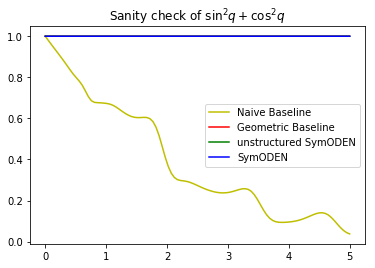

In [9]:
naive_1 = naive_ivp.y[0,:]**2 + naive_ivp.y[1,:]**2
base_1 = base_ivp.y[0,:]**2 + base_ivp.y[1,:]**2
hnn_1 = hnn_ivp.y[0,:]**2 + hnn_ivp.y[1,:]**2
hnn_struct_1 = hnn_struct_ivp.y[0,:]**2 + hnn_struct_ivp.y[1,:]**2

plt.plot(t_linspace_model, naive_1, 'y', label='Naive Baseline')
plt.plot(t_linspace_model, base_1, 'r', label='Geometric Baseline')
plt.plot(t_linspace_model, hnn_1, 'g', label='unstructured SymODEN')
plt.plot(t_linspace_model, hnn_struct_1, 'b', label='SymODEN')
plt.title(r'Sanity check of $\sin^2 q + \cos^2 q$')
plt.legend(fontsize=10)


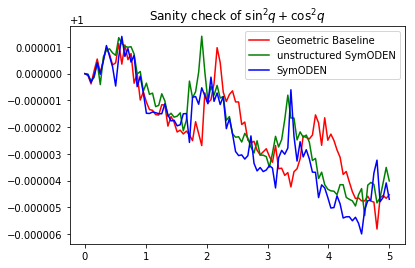

In [10]:
plt.plot(t_linspace_model, base_1, 'r', label='Geometric Baseline')
plt.plot(t_linspace_model, hnn_1, 'g', label='unstructured SymODEN')
plt.plot(t_linspace_model, hnn_struct_1, 'b', label='SymODEN')
plt.title(r'Sanity check of $\sin^2 q + \cos^2 q$')
plt.legend(fontsize=10)


 The Naive Baseline doesn't respect the geometry

 ## Plot learnt functions

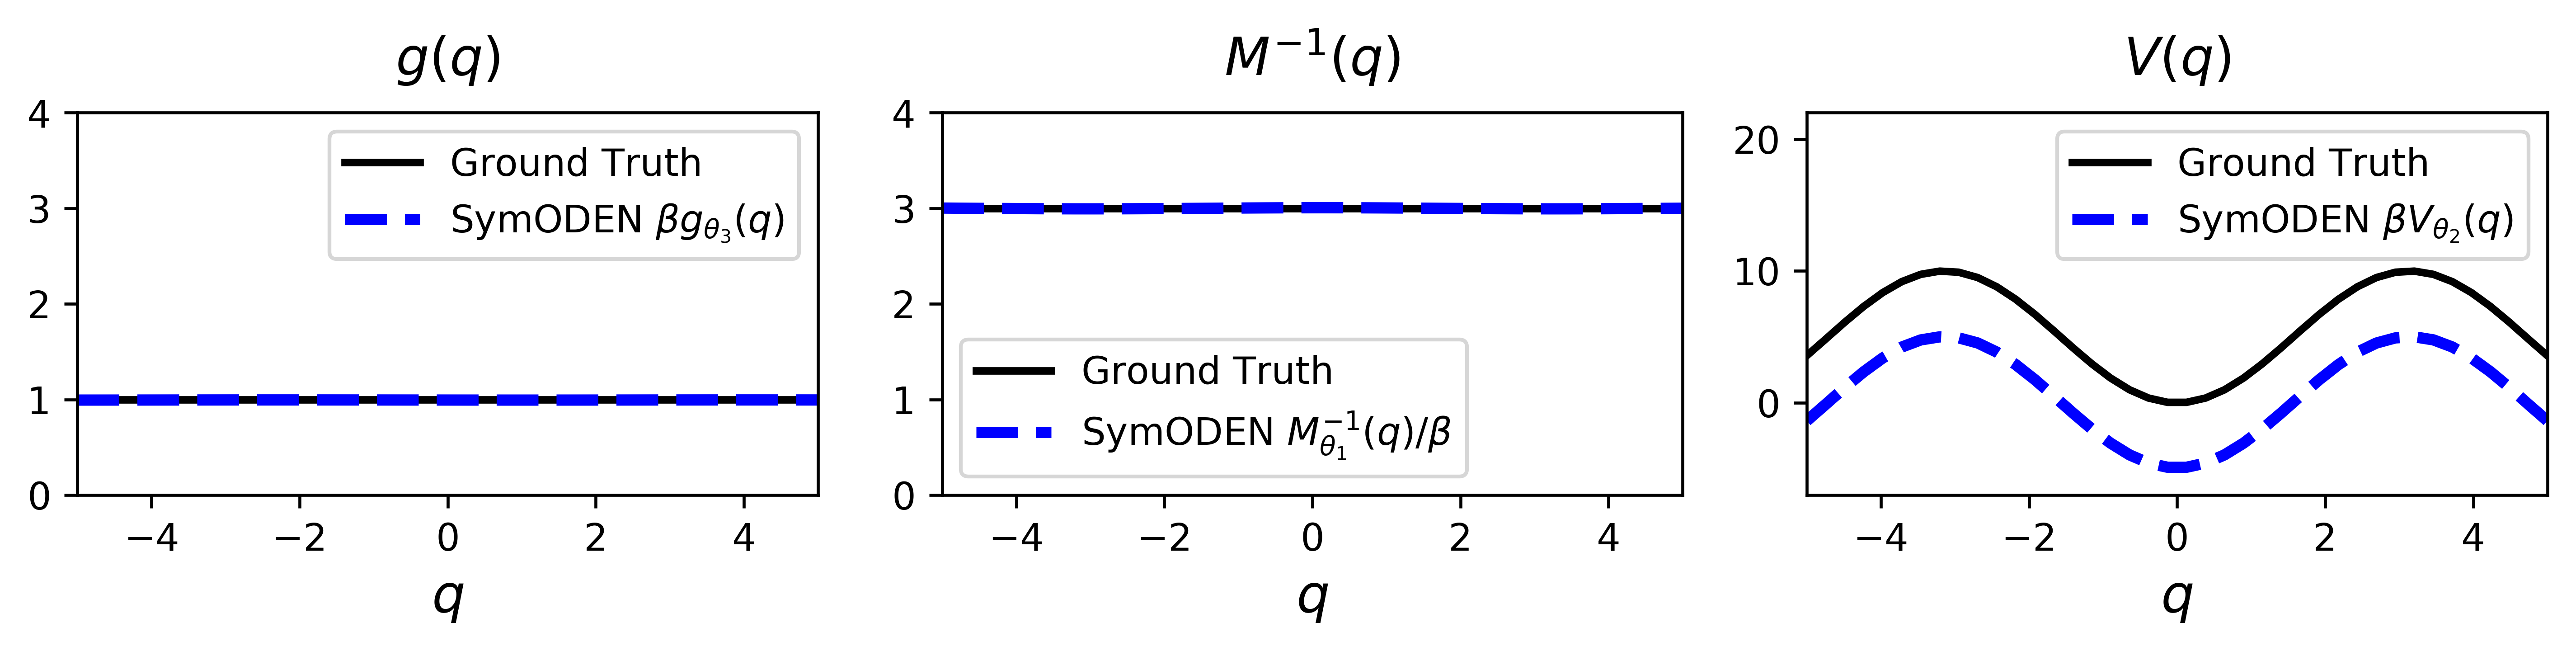

In [11]:

q = np.linspace(-5.0, 5.0, 40)
q_tensor = torch.tensor(q, dtype=torch.float32).view(40, 1).to(device)
cos_q_sin_q = torch.cat((-torch.cos(q_tensor), -torch.sin(q_tensor)), dim=1)

beta = 0.357
fig = plt.figure(figsize=(9.6, 2.5), dpi=DPI)
plt.subplot(1, 3, 1)

g_q = hnn_ode_struct_model.g_net(cos_q_sin_q)
plt.plot(q, np.ones_like(q), label='Ground Truth', color='k', linewidth=2)
plt.plot(q, beta * g_q.detach().cpu().numpy(), 'b--', linewidth=3, label=r'SymODEN $\beta g_{\theta_3}(q)$')
plt.xlabel("$q$", fontsize=14)
# plt.ylabel("$g(q)$", rotation=0, fontsize=14)
plt.title("$g(q)$", pad=10, fontsize=14)
plt.xlim(-5, 5)
plt.ylim(0, 4)
plt.legend(fontsize=10)

M_q_inv = hnn_ode_struct_model.M_net(cos_q_sin_q)
plt.subplot(1, 3, 2)
plt.plot(q, 3 * np.ones_like(q), label='Ground Truth', color='k', linewidth=2)
plt.plot(q, M_q_inv.detach().cpu().numpy()/beta, 'b--', linewidth=3, label=r'SymODEN $M^{-1}_{\theta_1}(q)/\beta$')
plt.xlabel("$q$", fontsize=14)
# plt.ylabel("$M^{-1}(q)$", rotation=0, fontsize=14)
plt.title("$M^{-1}(q)$", pad=10, fontsize=14)
plt.xlim(-5, 5)
plt.ylim(0, 4)
plt.legend(fontsize=10)

V_q = hnn_ode_struct_model.V_net(cos_q_sin_q)
plt.subplot(1, 3, 3)
plt.plot(q, 5.-5. * np.cos(q), label='Ground Truth', color='k', linewidth=2)
plt.plot(q, beta * V_q.detach().cpu().numpy(), 'b--', label=r'SymODEN $\beta V_{\theta_2}(q)$', linewidth=3)
plt.xlabel("$q$", fontsize=14)
# plt.ylabel("$V(q)$", rotation=0, fontsize=14)
plt.title("$V(q)$", pad=10, fontsize=14)
plt.xlim(-5, 5)
plt.ylim(-7, 22)
plt.legend(fontsize=10)
plt.tight_layout()
# fig.savefig('{}/fig-single-embed.{}'.format(args.fig_dir, FORMAT))


 ## Energy variation along each trajectory

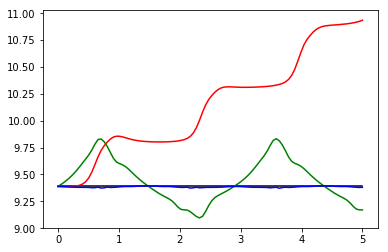

In [12]:

E_true = true_ivp.T[:, 2]**2 / 6 + 5 * (1 + true_ivp.T[:, 0])
E_base = base_ivp.y.T[:, 2]**2 / 6 + 5 * (1 + base_ivp.y.T[:, 0])
E_hnn = hnn_ivp.y.T[:, 2]**2 / 6 + 5 * (1 + hnn_ivp.y.T[:, 0])
E_hnn_struct = hnn_struct_ivp.y.T[:, 2]**2 / 6 + 5 * (1 + hnn_struct_ivp.y.T[:, 0])

plt.plot(t_linspace_true, E_true, 'k')
plt.plot(t_linspace_model, E_base, 'r')
plt.plot(t_linspace_model, E_hnn, 'g')
plt.plot(t_linspace_model, E_hnn_struct, 'b')


 ## Energy-based control
 The following code saves the rendering as a mp4 video and as a GIF at the same time

In [13]:
# time info for simualtion
time_step = 200 ; n_eval = 200
t_span = [0,time_step*0.05]
t_eval = torch.linspace(t_span[0], t_span[1], n_eval)
# angle info for simuation
init_angle = 3.14
u0 = 0.0

# generate initial condition from gym
import gym 
from gym import wrappers
import myenv

env = gym.make('MyPendulum-v0')
# record video
env = gym.wrappers.Monitor(env, './videos/' + 'single-embed' + '/', force=True) # , video_callable=lambda x: True, force=True

env.reset()
env.env.state = np.array([init_angle, u0], dtype=np.float32)
obs = env.env._get_obs()
y = torch.tensor([obs[0], obs[1], obs[2], u0], requires_grad=True, device=device, dtype=torch.float32).view(1, 4)


k_d = 3
y_traj = []
y_traj.append(y)
frames = []
for i in range(len(t_eval)-1):
    frames.append(env.render(mode='rgb_array'))

    cos_q_sin_q, q_dot, _ = torch.split(y, [2, 1, 1], dim=1)
    cos_q, sin_q = torch.chunk(cos_q_sin_q, 2, dim=1)
    V_q = hnn_ode_struct_model.V_net(cos_q_sin_q)
    g_q = hnn_ode_struct_model.g_net(cos_q_sin_q)
    dV = torch.autograd.grad(V_q, cos_q_sin_q)[0]
    dVdcos_q, dVdsin_q= torch.chunk(dV, 2, dim=1)
    dV_q = - dVdcos_q * sin_q + dVdsin_q * cos_q
    M_inv = hnn_ode_struct_model.M_net(cos_q_sin_q)
    q = torch.atan2(sin_q, cos_q)

    u = 1/g_q * (2*dV_q  - k_d * q_dot)

    # use openai simulator
    u = u.detach().cpu().numpy()
    obs, _, _, _ = env.step(u)
    y = torch.tensor([obs[0], obs[1], obs[2], u], requires_grad=True, device=device, dtype=torch.float32).view(1, 4)
    # use learnt model
    # y0_u = torch.cat((cos_q_sin_q, q_dot, u), dim = 1)
    # y_step = odeint(hnn_ode_struct_model, y0_u, t_eval[i:i+2], method='rk4')
    # y = y_step[-1,:,:]

    y_traj.append(y)
env.close()
imageio.mimsave('./videos/single-embed/single-embed.gif', frames, duration=0.05)

y_traj = torch.stack(y_traj).view(-1, 4).detach().cpu().numpy()


 ## Plot control results

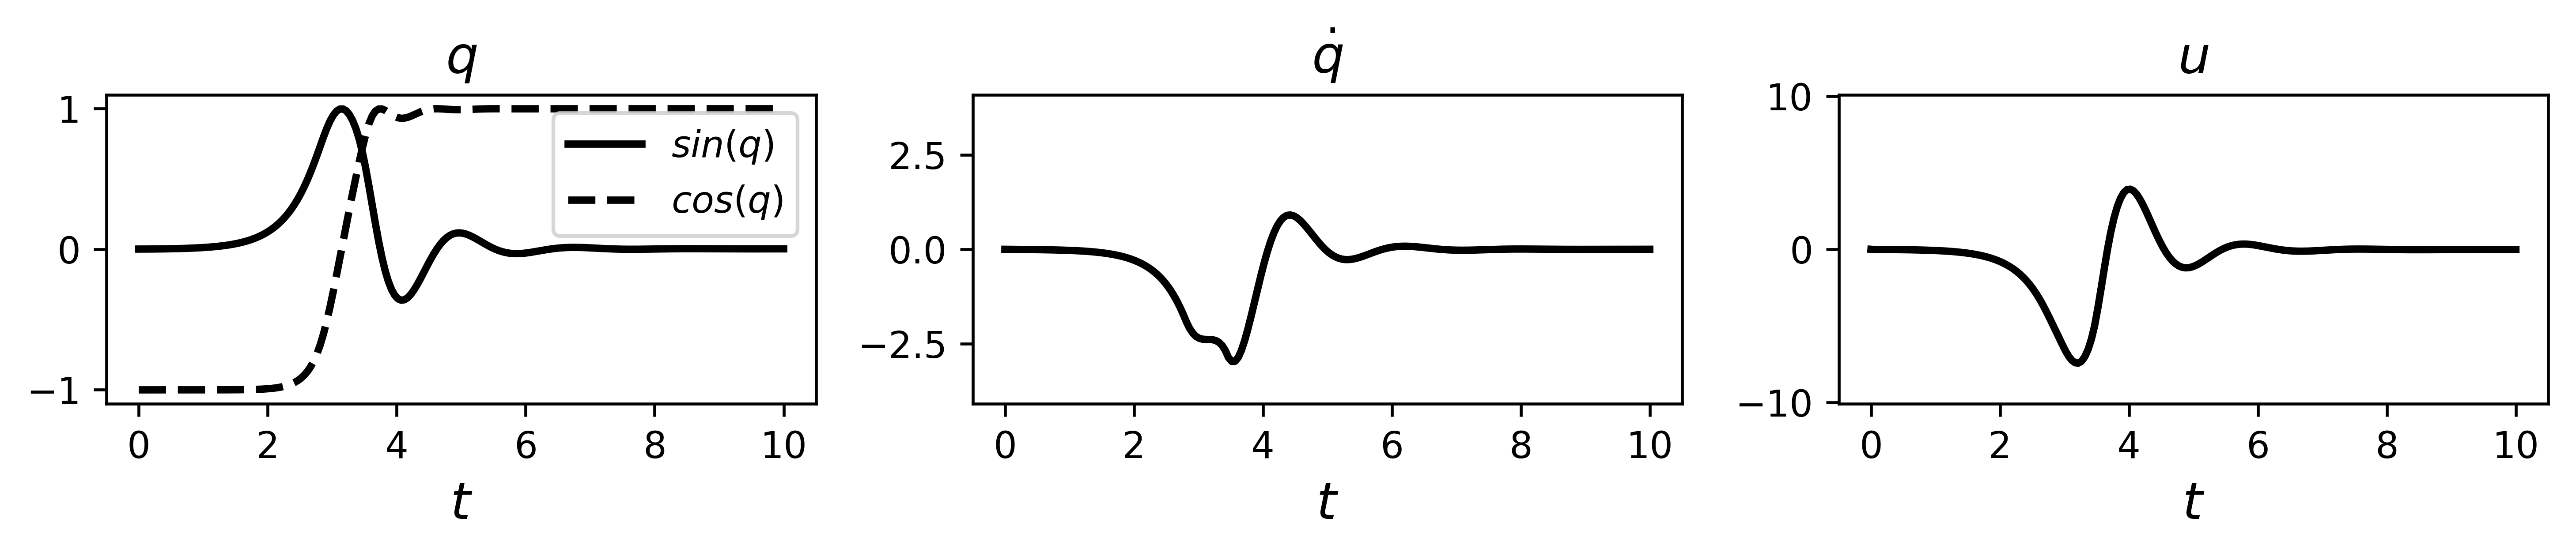

In [14]:
fig = plt.figure(figsize=[10, 2.2], dpi=DPI)

plt.subplot(1, 3, 1)
plt.plot(t_eval.numpy(), y_traj[:, 1], 'k', label=r'$sin(q)$', linewidth=2)
plt.plot(t_eval.numpy(), y_traj[:, 0], 'k--', label=r'$cos(q)$', linewidth=2)
plt.title('$q$', fontsize=14)
plt.xlabel('$t$', fontsize=14)
plt.ylim([-1.1, 1.1])
plt.legend(fontsize=10)

plt.subplot(1, 3, 2)
plt.plot(t_eval.numpy(), y_traj[:, 2], 'k', linewidth=2)
plt.title('$\dot{q}$', fontsize=14)
plt.xlabel('$t$', fontsize=14)
plt.ylim([-4.1, 4.1])

plt.subplot(1, 3, 3)
plt.plot(t_eval.numpy(), y_traj[:, 3], 'k', linewidth=2)
plt.title('$u$', fontsize=14)
plt.xlabel('$t$', fontsize=14)
plt.ylim([-10.1, 10.1])

plt.tight_layout() ; plt.show()
# fig.savefig('{}/fig-embed-ctrl.{}'.format(args.fig_dir, FORMAT))
